In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import pickle
import optuna as optuna
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.inspection import permutation_importance

In [ ]:
path = "../../Dataset/24months/"
x_train = pd.read_csv(path + "X_train_winsorized.csv")
y_train = pd.read_csv(path + "Y_train_winsorized.csv")
x_validation = pd.read_csv(path + "X_validation.csv")
y_validation = pd.read_csv(path + "Y_validation.csv")
x_test = pd.read_csv(path + "X_test.csv")
y_test = pd.read_csv(path + "Y_test.csv")

In [366]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_validation.shape, y_validation.shape

((1084578, 47), (1084578, 1), (36537, 47), (36537, 1), (58299, 47), (58299, 1))

In [367]:
x_train = x_train.drop(columns=['StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey','day'])
x_test = x_test.drop(columns=['StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey','day'])
x_validation = x_validation.drop(columns=['StartDate','EventDate','Duration','tic', 'dummy297fin', 'gvkey','day'])

In [368]:
x_train.columns

Index(['StkIndx', 'STInt', 'dtdlevel', 'dtdtrend', 'liqnonfinlevel',
       'liqnonfintrend', 'ni2talevel', 'ni2tatrend', 'sizelevel', 'sizetrend',
       'm2b', 'sigma', 'liqfinlevel', 'lqfintrend', 'DTDmedianFin',
       'DTDmedianNonFin', 'current_ratio', 'quick_ratio', 'cash_ratio',
       'net_working_capital', 'debt_ratio', 'debt_to_equity_ratio',
       'equity_ratio', 'cashflow_to_debt_ratio', 'net_profit_margin',
       'return_on_assets', 'asset_turnover', 'inventory_turnover',
       'days_in_inventory', 'receivables_turnover', 'day_sales_outstanding',
       'working_capital_turnover', 'price_to_earnings',
       'dividend_payout_ratio', 'retention_ratio', 'gross_margin_ratio',
       'operating_profit_margin', 'ebitda_margin',
       'debt_service_coverage_ratio', 'interest_coverage_ratio'],
      dtype='object')

In [369]:
# mini sample to try:
msk = np.random.rand(len(x_train)) < 0.0001
x_train_sample=x_train[msk]
y_train_sample=y_train[msk]

In [370]:
# WARNING: 2 changes to change evaluation metric
optimisation_metric = "recall" #"accuracy" "recall" "precision" "f1" "auc"
def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'objective': 'binary',
        'metric': 'recall', #"accuracy" "recall" "precision" "f1" "auc"
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        # 'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        # 'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 10.0, log=True),
        'scale_pos_weight': 100,
        'max_depth': trial.suggest_int('max_depth', 2, 256),
        'num_boost_round': trial.suggest_int('num_boost_round', 100, 500),
    }
    
    # full data
    gbm = lgb.train(param, lgb.Dataset(x_train, y_train))
    
    preds = gbm.predict(x_validation)
    y_pred_binary = np.round(preds)
    
    auc = roc_auc_score(y_validation, preds)
    accuracy = accuracy_score(y_validation, y_pred_binary)
    recall = recall_score(y_validation, y_pred_binary)
    precision = precision_score(y_validation, y_pred_binary)
    f1 = f1_score(y_validation, y_pred_binary)
    
    #choose the metric you want to optimized
    if optimisation_metric == 'recall': 
        return recall
    elif optimisation_metric == 'precision': 
        return precision
    elif optimisation_metric == 'f1':
        return f1
    elif optimisation_metric == 'auc':
        return auc
    elif optimisation_metric == 'accuracy': 
        return accuracy
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

[I 2023-11-06 20:58:25,826] A new study created in memory with name: no-name-c3a95807-3375-45b0-8d0c-af5185b1c308
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 20:59:03,097] Trial 0 finished with value: 0.0 and parameters: {'num_leaves': 227, 'lambda_l1': 0.01515899949125819, 'lambda_l2': 0.696574880398133, 'feature_fraction': 0.9001669552481527, 'min_child_samples': 46, 'learning_rate': 0.002364573120833055, 'max_depth': 228, 'num_boost_round': 235}. Best is trial 0 with value: 0.0.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.132069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there 

[I 2023-11-06 20:59:17,223] Trial 1 finished with value: 0.7626582278481012 and parameters: {'num_leaves': 182, 'lambda_l1': 0.20491286826198218, 'lambda_l2': 0.1476774689195542, 'feature_fraction': 0.8802338885470652, 'min_child_samples': 21, 'learning_rate': 1.6246475098648077, 'max_depth': 3, 'num_boost_round': 403}. Best is trial 1 with value: 0.7626582278481012.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements


c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 20:59:32,801] Trial 2 finished with value: 0.6424050632911392 and parameters: {'num_leaves': 182, 'lambda_l1': 0.839193465710327, 'lambda_l2': 0.008166340214096467, 'feature_fraction': 0.7639571998203813, 'min_child_samples': 41, 'learning_rate': 0.008084229144750953, 'max_depth': 139, 'num_boost_round': 116}. Best is trial 1 with value: 0.7626582278481012.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:00:07,828] Trial 3 finished with value: 0.0 and parameters: {'num_leaves': 192, 'lambda_l1': 7.418918773179279, 'lambda_l2': 0.002572298845443118, 'feature_fraction': 0.8261521003767196, 'min_child_samples': 75, 'learning_rate': 1.4801021415329163e-06, 'max_depth': 174, 'num_boost_round': 267}. Best is trial 1 with value: 0.7626582278481012.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:00:31,950] Trial 4 finished with value: 0.0 and parameters: {'num_leaves': 204, 'lambda_l1': 4.4594063532024715e-08, 'lambda_l2': 2.6593233264435897e-07, 'feature_fraction': 0.6407312465358956, 'min_child_samples': 59, 'learning_rate': 6.578331141939775e-05, 'max_depth': 61, 'num_boost_round': 225}. Best is trial 1 with value: 0.7626582278481012.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:00:57,234] Trial 5 finished with value: 0.0 and parameters: {'num_leaves': 114, 'lambda_l1': 9.522897663201183e-06, 'lambda_l2': 0.010663266018026168, 'feature_fraction': 0.761782548600294, 'min_child_samples': 29, 'learning_rate': 2.1615273555787364e-07, 'max_depth': 196, 'num_boost_round': 289}. Best is trial 1 with value: 0.7626582278481012.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:01:28,457] Trial 6 finished with value: 0.0 and parameters: {'num_leaves': 157, 'lambda_l1': 7.466627328271853, 'lambda_l2': 9.755177431270205e-07, 'feature_fraction': 0.5857370513579413, 'min_child_samples': 53, 'learning_rate': 1.1576525148932302e-05, 'max_depth': 90, 'num_boost_round': 400}. Best is trial 1 with value: 0.7626582278481012.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.129256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2023-11-06 21:01:39,458] Trial 7 finished with value: 0.8291139240506329 and parameters: {'num_leaves': 211, 'lambda_l1': 5.686265701635209e-07, 'lambda_l2': 5.019909056783986e-05, 'feature_fraction': 0.8708168069751607, 'min_child_samples': 93, 'learning_rate': 0.26271299616774774, 'max_depth': 253, 'num_boost_round': 123}. Best is trial 7 with value: 0.8291139240506329.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] St

[I 2023-11-06 21:01:53,171] Trial 8 finished with value: 0.20569620253164558 and parameters: {'num_leaves': 116, 'lambda_l1': 1.0557979806775211e-06, 'lambda_l2': 0.5485944775645761, 'feature_fraction': 0.8593724571781265, 'min_child_samples': 93, 'learning_rate': 3.882589239274766, 'max_depth': 180, 'num_boost_round': 425}. Best is trial 7 with value: 0.8291139240506329.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.118434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No

[I 2023-11-06 21:02:09,136] Trial 9 finished with value: 0.8670886075949367 and parameters: {'num_leaves': 112, 'lambda_l1': 0.00996899746702714, 'lambda_l2': 9.111231679577961e-05, 'feature_fraction': 0.40944537020134947, 'min_child_samples': 17, 'learning_rate': 0.39361209037282785, 'max_depth': 47, 'num_boost_round': 396}. Best is trial 9 with value: 0.8670886075949367.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:02:29,379] Trial 10 finished with value: 0.8037974683544303 and parameters: {'num_leaves': 42, 'lambda_l1': 0.0009260057902320792, 'lambda_l2': 2.7904044615365353e-05, 'feature_fraction': 0.4029640713092058, 'min_child_samples': 5, 'learning_rate': 0.03849475219194847, 'max_depth': 9, 'num_boost_round': 485}. Best is trial 9 with value: 0.8670886075949367.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:02:38,082] Trial 11 finished with value: 0.8955696202531646 and parameters: {'num_leaves': 63, 'lambda_l1': 0.0002333270054680362, 'lambda_l2': 2.8513193919285824e-05, 'feature_fraction': 0.9436651139133263, 'min_child_samples': 96, 'learning_rate': 0.49501563938023074, 'max_depth': 253, 'num_boost_round': 115}. Best is trial 11 with value: 0.8955696202531646.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leave

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:02:51,100] Trial 12 finished with value: 0.0 and parameters: {'num_leaves': 54, 'lambda_l1': 0.00028899551360680434, 'lambda_l2': 1.4651380949238876e-08, 'feature_fraction': 0.945105694222993, 'min_child_samples': 75, 'learning_rate': 6.730860664925529, 'max_depth': 71, 'num_boost_round': 350}. Best is trial 11 with value: 0.8955696202531646.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.118866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:02:56,317] Trial 13 finished with value: 0.9367088607594937 and parameters: {'num_leaves': 5, 'lambda_l1': 0.0006553373670477706, 'lambda_l2': 0.00014429395273444655, 'feature_fraction': 0.40061585132158384, 'min_child_samples': 9, 'learning_rate': 0.09543119280271267, 'max_depth': 120, 'num_boost_round': 181}. Best is trial 13 with value: 0.9367088607594937.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:03:05,247] Trial 14 finished with value: 0.0 and parameters: {'num_leaves': 7, 'lambda_l1': 5.9956490814839224e-05, 'lambda_l2': 0.0003288589199488499, 'feature_fraction': 0.9661680691923168, 'min_child_samples': 72, 'learning_rate': 0.0007846344696700421, 'max_depth': 136, 'num_boost_round': 175}. Best is trial 13 with value: 0.9367088607594937.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:03:20,091] Trial 15 finished with value: 0.7658227848101266 and parameters: {'num_leaves': 71, 'lambda_l1': 0.0015740229998288037, 'lambda_l2': 3.3641503602490313e-06, 'feature_fraction': 0.9854747787136221, 'min_child_samples': 99, 'learning_rate': 0.05024473585941022, 'max_depth': 110, 'num_boost_round': 167}. Best is trial 13 with value: 0.9367088607594937.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:03:24,185] Trial 16 finished with value: 0.9145569620253164 and parameters: {'num_leaves': 2, 'lambda_l1': 7.787066061380137e-05, 'lambda_l2': 8.291294483476635, 'feature_fraction': 0.5296769852553453, 'min_child_samples': 84, 'learning_rate': 0.015188121607753848, 'max_depth': 158, 'num_boost_round': 175}. Best is trial 13 with value: 0.9367088607594937.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.121364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:03:32,618] Trial 17 finished with value: 0.0 and parameters: {'num_leaves': 8, 'lambda_l1': 1.802067582320508e-05, 'lambda_l2': 7.067819408979334, 'feature_fraction': 0.49421536465018845, 'min_child_samples': 62, 'learning_rate': 0.0003377538503244541, 'max_depth': 154, 'num_boost_round': 195}. Best is trial 13 with value: 0.9367088607594937.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:03:50,029] Trial 18 finished with value: 0.9113924050632911 and parameters: {'num_leaves': 31, 'lambda_l1': 0.006182246441374908, 'lambda_l2': 0.0013208041890405042, 'feature_fraction': 0.5054988869807985, 'min_child_samples': 36, 'learning_rate': 0.011189247086491669, 'max_depth': 114, 'num_boost_round': 329}. Best is trial 13 with value: 0.9367088607594937.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:04:00,939] Trial 19 finished with value: 0.0 and parameters: {'num_leaves': 87, 'lambda_l1': 6.39437562714856e-05, 'lambda_l2': 0.06336762536133886, 'feature_fraction': 0.5083870050205648, 'min_child_samples': 83, 'learning_rate': 0.0021748761817889867, 'max_depth': 200, 'num_boost_round': 153}. Best is trial 13 with value: 0.9367088607594937.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.132262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:04:22,821] Trial 20 finished with value: 0.0 and parameters: {'num_leaves': 251, 'lambda_l1': 4.915827942245501e-06, 'lambda_l2': 0.0005610069951130227, 'feature_fraction': 0.5805288835537298, 'min_child_samples': 66, 'learning_rate': 1.0012738809953755e-08, 'max_depth': 163, 'num_boost_round': 220}. Best is trial 13 with value: 0.9367088607594937.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:04:39,742] Trial 21 finished with value: 0.8987341772151899 and parameters: {'num_leaves': 31, 'lambda_l1': 0.005258660410897507, 'lambda_l2': 5.53076239309798, 'feature_fraction': 0.46766301790983034, 'min_child_samples': 33, 'learning_rate': 0.01794775197958031, 'max_depth': 111, 'num_boost_round': 332}. Best is trial 13 with value: 0.9367088607594937.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:04:53,450] Trial 22 finished with value: 0.8069620253164557 and parameters: {'num_leaves': 26, 'lambda_l1': 0.05872707264614281, 'lambda_l2': 0.001396628009287611, 'feature_fraction': 0.45353173540055447, 'min_child_samples': 6, 'learning_rate': 0.07261727089004041, 'max_depth': 99, 'num_boost_round': 317}. Best is trial 13 with value: 0.9367088607594937.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:05:02,873] Trial 23 finished with value: 0.7784810126582279 and parameters: {'num_leaves': 7, 'lambda_l1': 0.0017940608734903826, 'lambda_l2': 0.015930514184692986, 'feature_fraction': 0.5229172728237178, 'min_child_samples': 16, 'learning_rate': 0.004354866859452481, 'max_depth': 130, 'num_boost_round': 264}. Best is trial 13 with value: 0.9367088607594937.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.114925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:05:20,929] Trial 24 finished with value: 0.9177215189873418 and parameters: {'num_leaves': 29, 'lambda_l1': 0.00026534431158452835, 'lambda_l2': 0.0019324291342281245, 'feature_fraction': 0.5454986186989103, 'min_child_samples': 40, 'learning_rate': 0.007802260978302231, 'max_depth': 83, 'num_boost_round': 351}. Best is trial 13 with value: 0.9367088607594937.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:05:39,575] Trial 25 finished with value: 0.4430379746835443 and parameters: {'num_leaves': 87, 'lambda_l1': 0.00011283554015164127, 'lambda_l2': 0.0002309065921485134, 'feature_fraction': 0.5494500813056163, 'min_child_samples': 26, 'learning_rate': 0.1084315276855768, 'max_depth': 38, 'num_boost_round': 364}. Best is trial 13 with value: 0.9367088607594937.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:06:02,934] Trial 26 finished with value: 0.0 and parameters: {'num_leaves': 23, 'lambda_l1': 0.0005879932477083102, 'lambda_l2': 0.021735796614601302, 'feature_fraction': 0.6197312768829328, 'min_child_samples': 50, 'learning_rate': 0.0007240813032496303, 'max_depth': 91, 'num_boost_round': 449}. Best is trial 13 with value: 0.9367088607594937.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:06:20,181] Trial 27 finished with value: 0.9113924050632911 and parameters: {'num_leaves': 48, 'lambda_l1': 3.0501448892976906e-05, 'lambda_l2': 0.12981757748159145, 'feature_fraction': 0.4537596397091531, 'min_child_samples': 87, 'learning_rate': 0.017747656679048023, 'max_depth': 77, 'num_boost_round': 285}. Best is trial 13 with value: 0.9367088607594937.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leave

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:06:26,878] Trial 28 finished with value: 0.0 and parameters: {'num_leaves': 2, 'lambda_l1': 0.00013407763762066397, 'lambda_l2': 0.002487548020862113, 'feature_fraction': 0.6632685991669093, 'min_child_samples': 38, 'learning_rate': 1.229261625211968, 'max_depth': 152, 'num_boost_round': 196}. Best is trial 13 with value: 0.9367088607594937.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:06:47,282] Trial 29 finished with value: 0.0 and parameters: {'num_leaves': 86, 'lambda_l1': 0.03387602765802982, 'lambda_l2': 0.5156926413751579, 'feature_fraction': 0.5522392048086371, 'min_child_samples': 48, 'learning_rate': 0.0021508472575197135, 'max_depth': 210, 'num_boost_round': 243}. Best is trial 13 with value: 0.9367088607594937.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:06:55,121] Trial 30 finished with value: 0.40822784810126583 and parameters: {'num_leaves': 159, 'lambda_l1': 0.0004788044840135151, 'lambda_l2': 2.0275079536991023, 'feature_fraction': 0.4306178182236874, 'min_child_samples': 14, 'learning_rate': 0.16112853217521445, 'max_depth': 29, 'num_boost_round': 135}. Best is trial 13 with value: 0.9367088607594937.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:07:12,723] Trial 31 finished with value: 0.9367088607594937 and parameters: {'num_leaves': 17, 'lambda_l1': 0.006884112455293803, 'lambda_l2': 0.0011999832339973143, 'feature_fraction': 0.4857214074488763, 'min_child_samples': 41, 'learning_rate': 0.011106407081049846, 'max_depth': 112, 'num_boost_round': 361}. Best is trial 13 with value: 0.9367088607594937.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:07:33,256] Trial 32 finished with value: 0.9082278481012658 and parameters: {'num_leaves': 20, 'lambda_l1': 0.0031426803556554163, 'lambda_l2': 0.05422357638475383, 'feature_fraction': 0.47271318215253466, 'min_child_samples': 43, 'learning_rate': 0.004846835125796634, 'max_depth': 124, 'num_boost_round': 377}. Best is trial 13 with value: 0.9367088607594937.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.132550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:07:52,809] Trial 33 finished with value: 0.8860759493670886 and parameters: {'num_leaves': 46, 'lambda_l1': 0.02515425596741156, 'lambda_l2': 0.2912345383503904, 'feature_fraction': 0.43408664439113526, 'min_child_samples': 24, 'learning_rate': 0.02468916026364338, 'max_depth': 79, 'num_boost_round': 314}. Best is trial 13 with value: 0.9367088607594937.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.121002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:07:58,255] Trial 34 finished with value: 0.8955696202531646 and parameters: {'num_leaves': 17, 'lambda_l1': 0.0013060168951457398, 'lambda_l2': 0.0043493567970388355, 'feature_fraction': 0.4843239826077748, 'min_child_samples': 56, 'learning_rate': 0.07915231901267623, 'max_depth': 145, 'num_boost_round': 100}. Best is trial 13 with value: 0.9367088607594937.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:08:25,433] Trial 35 finished with value: 0.9113924050632911 and parameters: {'num_leaves': 41, 'lambda_l1': 0.12121677152804394, 'lambda_l2': 1.7206028314961652, 'feature_fraction': 0.5371694179872706, 'min_child_samples': 44, 'learning_rate': 0.0065242953554953175, 'max_depth': 58, 'num_boost_round': 433}. Best is trial 13 with value: 0.9367088607594937.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split require

[I 2023-11-06 21:08:36,602] Trial 36 finished with value: 0.7025316455696202 and parameters: {'num_leaves': 65, 'lambda_l1': 0.01172884999156599, 'lambda_l2': 0.008226650615520388, 'feature_fraction': 0.4416845928515996, 'min_child_samples': 32, 'learning_rate': 0.7991011070250437, 'max_depth': 178, 'num_boost_round': 245}. Best is trial 13 with value: 0.9367088607594937.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:08:50,596] Trial 37 finished with value: 0.7658227848101266 and parameters: {'num_leaves': 33, 'lambda_l1': 0.6375912120417458, 'lambda_l2': 0.03386033853467436, 'feature_fraction': 0.5796708713404937, 'min_child_samples': 67, 'learning_rate': 0.21691616372902514, 'max_depth': 120, 'num_boost_round': 353}. Best is trial 13 with value: 0.9367088607594937.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.202483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:09:02,376] Trial 38 finished with value: 0.939873417721519 and parameters: {'num_leaves': 16, 'lambda_l1': 0.00027635977170900784, 'lambda_l2': 0.1804419252512156, 'feature_fraction': 0.4049898756503032, 'min_child_samples': 10, 'learning_rate': 0.016154536409690595, 'max_depth': 105, 'num_boost_round': 204}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leave

[I 2023-11-06 21:09:11,036] Trial 39 finished with value: 0.9018987341772152 and parameters: {'num_leaves': 77, 'lambda_l1': 0.00035594873179562163, 'lambda_l2': 0.00497672392873117, 'feature_fraction': 0.4031633332601853, 'min_child_samples': 11, 'learning_rate': 2.531585465564687, 'max_depth': 100, 'num_boost_round': 207}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.162652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:09:33,342] Trial 40 finished with value: 0.0 and parameters: {'num_leaves': 132, 'lambda_l1': 0.004767052040161064, 'lambda_l2': 0.0009015703981080655, 'feature_fraction': 0.4816018013435101, 'min_child_samples': 22, 'learning_rate': 8.960529658373607e-05, 'max_depth': 87, 'num_boost_round': 273}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:09:40,683] Trial 41 finished with value: 0.9272151898734177 and parameters: {'num_leaves': 18, 'lambda_l1': 0.0001416100132648121, 'lambda_l2': 0.1946401327625346, 'feature_fraction': 0.43191619438927065, 'min_child_samples': 11, 'learning_rate': 0.017517991951081488, 'max_depth': 136, 'num_boost_round': 157}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:09:47,482] Trial 42 finished with value: 0.6582278481012658 and parameters: {'num_leaves': 17, 'lambda_l1': 0.0009549646164733871, 'lambda_l2': 0.18092490290690208, 'feature_fraction': 0.4300269676598755, 'min_child_samples': 12, 'learning_rate': 0.006879928024134796, 'max_depth': 138, 'num_boost_round': 130}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:09:57,768] Trial 43 finished with value: 0.8955696202531646 and parameters: {'num_leaves': 52, 'lambda_l1': 0.0002655042345227415, 'lambda_l2': 0.014574427524222089, 'feature_fraction': 0.4003760212493741, 'min_child_samples': 19, 'learning_rate': 0.03664889665142466, 'max_depth': 104, 'num_boost_round': 155}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:10:10,268] Trial 44 finished with value: 0.7215189873417721 and parameters: {'num_leaves': 35, 'lambda_l1': 0.0019145244366679341, 'lambda_l2': 0.00013835303260511592, 'feature_fraction': 0.4591508066836917, 'min_child_samples': 7, 'learning_rate': 0.18797268757877453, 'max_depth': 66, 'num_boost_round': 375}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:10:23,537] Trial 45 finished with value: 0.0 and parameters: {'num_leaves': 15, 'lambda_l1': 0.01352277555442607, 'lambda_l2': 0.10065557832350548, 'feature_fraction': 0.4216578614737948, 'min_child_samples': 28, 'learning_rate': 0.0017268404403242986, 'max_depth': 130, 'num_boost_round': 302}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:10:32,936] Trial 46 finished with value: 0.7088607594936709 and parameters: {'num_leaves': 54, 'lambda_l1': 0.0001555080385702041, 'lambda_l2': 0.0004947308933975975, 'feature_fraction': 0.4932214383862355, 'min_child_samples': 10, 'learning_rate': 0.429166341910985, 'max_depth': 89, 'num_boost_round': 189}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:10:48,484] Trial 47 finished with value: 0.8512658227848101 and parameters: {'num_leaves': 18, 'lambda_l1': 0.0027374093178116916, 'lambda_l2': 0.0030806788177396237, 'feature_fraction': 0.4425733527720225, 'min_child_samples': 19, 'learning_rate': 0.05820748827669593, 'max_depth': 53, 'num_boost_round': 407}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.129128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:10:59,329] Trial 48 finished with value: 0.8544303797468354 and parameters: {'num_leaves': 101, 'lambda_l1': 0.0007842360584686271, 'lambda_l2': 0.03770599994774255, 'feature_fraction': 0.4012160222078606, 'min_child_samples': 39, 'learning_rate': 0.031045865299753065, 'max_depth': 165, 'num_boost_round': 146}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:11:14,619] Trial 49 finished with value: 0.8987341772151899 and parameters: {'num_leaves': 62, 'lambda_l1': 3.946248717339962e-05, 'lambda_l2': 5.144133798009899e-05, 'feature_fraction': 0.47110620417890203, 'min_child_samples': 33, 'learning_rate': 0.00977053208398339, 'max_depth': 118, 'num_boost_round': 219}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.132846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:11:29,882] Trial 50 finished with value: 0.0 and parameters: {'num_leaves': 38, 'lambda_l1': 8.716419316344204e-06, 'lambda_l2': 0.23662904966942647, 'feature_fraction': 0.4314317316630763, 'min_child_samples': 23, 'learning_rate': 0.0009942269263784262, 'max_depth': 145, 'num_boost_round': 254}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:11:36,190] Trial 51 finished with value: 0.9240506329113924 and parameters: {'num_leaves': 3, 'lambda_l1': 7.61199911552126e-05, 'lambda_l2': 1.012925972535235, 'feature_fraction': 0.5108225252431491, 'min_child_samples': 8, 'learning_rate': 0.016144932416518442, 'max_depth': 160, 'num_boost_round': 175}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.142771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:11:45,130] Trial 52 finished with value: 0.0 and parameters: {'num_leaves': 11, 'lambda_l1': 0.00016607993636093903, 'lambda_l2': 1.1340639716688488, 'feature_fraction': 0.5172447239101907, 'min_child_samples': 7, 'learning_rate': 0.0038651982741836374, 'max_depth': 191, 'num_boost_round': 169}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:11:56,850] Trial 53 finished with value: 0.9082278481012658 and parameters: {'num_leaves': 23, 'lambda_l1': 0.0004257164209076243, 'lambda_l2': 0.73695287845952, 'feature_fraction': 0.49848024512948536, 'min_child_samples': 14, 'learning_rate': 0.010131077960365135, 'max_depth': 103, 'num_boost_round': 187}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:12:05,418] Trial 54 finished with value: 0.939873417721519 and parameters: {'num_leaves': 7, 'lambda_l1': 7.338404240445057e-05, 'lambda_l2': 0.33080342472801527, 'feature_fraction': 0.4587438541736943, 'min_child_samples': 9, 'learning_rate': 0.029396298576264527, 'max_depth': 172, 'num_boost_round': 227}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:12:10,654] Trial 55 finished with value: 0.9335443037974683 and parameters: {'num_leaves': 2, 'lambda_l1': 2.2201476657881168e-05, 'lambda_l2': 0.4169506049284282, 'feature_fraction': 0.45443196654919815, 'min_child_samples': 5, 'learning_rate': 0.10053510141863746, 'max_depth': 169, 'num_boost_round': 226}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:12:17,967] Trial 56 finished with value: 0.8006329113924051 and parameters: {'num_leaves': 10, 'lambda_l1': 2.5580365301300015e-05, 'lambda_l2': 0.39830576127946965, 'feature_fraction': 0.4171845149875519, 'min_child_samples': 5, 'learning_rate': 0.1245999734814658, 'max_depth': 221, 'num_boost_round': 227}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.162935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:12:27,553] Trial 57 finished with value: 0.7943037974683544 and parameters: {'num_leaves': 26, 'lambda_l1': 5.038793426247743e-06, 'lambda_l2': 0.19148468007003752, 'feature_fraction': 0.45570131946018616, 'min_child_samples': 17, 'learning_rate': 0.4017012604906787, 'max_depth': 189, 'num_boost_round': 209}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:12:41,013] Trial 58 finished with value: 0.8607594936708861 and parameters: {'num_leaves': 41, 'lambda_l1': 1.7102713146985313e-05, 'lambda_l2': 0.08401629879518742, 'feature_fraction': 0.4216894333849955, 'min_child_samples': 11, 'learning_rate': 0.05049828095794502, 'max_depth': 171, 'num_boost_round': 230}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leave

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:12:49,094] Trial 59 finished with value: 0.0 and parameters: {'num_leaves': 2, 'lambda_l1': 4.903730599067129e-05, 'lambda_l2': 2.3314852417005834, 'feature_fraction': 0.4685281772305872, 'min_child_samples': 14, 'learning_rate': 0.9494683187631205, 'max_depth': 147, 'num_boost_round': 207}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.132210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:13:14,089] Trial 60 finished with value: 0.2626582278481013 and parameters: {'num_leaves': 238, 'lambda_l1': 0.00011698890193935663, 'lambda_l2': 0.4902483595727282, 'feature_fraction': 0.48521255980442085, 'min_child_samples': 20, 'learning_rate': 0.11527019462932056, 'max_depth': 135, 'num_boost_round': 280}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.131167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:13:22,199] Trial 61 finished with value: 0.9367088607594937 and parameters: {'num_leaves': 10, 'lambda_l1': 6.559886449539414e-05, 'lambda_l2': 1.0057846722998034, 'feature_fraction': 0.4433471252148534, 'min_child_samples': 9, 'learning_rate': 0.01899408481895988, 'max_depth': 127, 'num_boost_round': 182}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:13:29,509] Trial 62 finished with value: 0.9240506329113924 and parameters: {'num_leaves': 12, 'lambda_l1': 0.0007898981503104639, 'lambda_l2': 3.5169041204300444, 'feature_fraction': 0.44913252266619424, 'min_child_samples': 9, 'learning_rate': 0.03563942962927013, 'max_depth': 108, 'num_boost_round': 156}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:13:39,548] Trial 63 finished with value: 0.9177215189873418 and parameters: {'num_leaves': 25, 'lambda_l1': 6.368246357109581e-05, 'lambda_l2': 0.9207933447958274, 'feature_fraction': 0.4185746712196625, 'min_child_samples': 15, 'learning_rate': 0.021463205283402294, 'max_depth': 126, 'num_boost_round': 185}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.141392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:13:45,154] Trial 64 finished with value: 0.8860759493670886 and parameters: {'num_leaves': 11, 'lambda_l1': 0.00023058508350884725, 'lambda_l2': 0.3368112492602904, 'feature_fraction': 0.4438273545090316, 'min_child_samples': 5, 'learning_rate': 0.0852553035277866, 'max_depth': 115, 'num_boost_round': 115}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:13:56,503] Trial 65 finished with value: 0.4588607594936709 and parameters: {'num_leaves': 199, 'lambda_l1': 2.1891509920514414e-05, 'lambda_l2': 0.06973510892160659, 'feature_fraction': 0.4671995267683187, 'min_child_samples': 12, 'learning_rate': 0.19319540959672893, 'max_depth': 183, 'num_boost_round': 141}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.130304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:14:11,930] Trial 66 finished with value: 0.24050632911392406 and parameters: {'num_leaves': 28, 'lambda_l1': 0.00010193312364620764, 'lambda_l2': 3.7365759640849117, 'feature_fraction': 0.4138611538121231, 'min_child_samples': 17, 'learning_rate': 0.0028162156585356123, 'max_depth': 171, 'num_boost_round': 260}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:14:28,221] Trial 67 finished with value: 0.9082278481012658 and parameters: {'num_leaves': 34, 'lambda_l1': 0.000593717913375689, 'lambda_l2': 7.864472286971866, 'feature_fraction': 0.44873669097936686, 'min_child_samples': 9, 'learning_rate': 0.01131664326996908, 'max_depth': 153, 'num_boost_round': 241}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:14:47,447] Trial 68 finished with value: 0.7563291139240507 and parameters: {'num_leaves': 159, 'lambda_l1': 3.547636070283839e-05, 'lambda_l2': 0.13756018961674948, 'feature_fraction': 0.49264696764597127, 'min_child_samples': 26, 'learning_rate': 0.04480841905831049, 'max_depth': 208, 'num_boost_round': 161}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:14:57,181] Trial 69 finished with value: 0.930379746835443 and parameters: {'num_leaves': 19, 'lambda_l1': 1.7768572617418212e-06, 'lambda_l2': 0.02265253598379523, 'feature_fraction': 0.4003797228557776, 'min_child_samples': 20, 'learning_rate': 0.019757037904871523, 'max_depth': 95, 'num_boost_round': 202}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:15:15,769] Trial 70 finished with value: 0.75 and parameters: {'num_leaves': 174, 'lambda_l1': 2.7681766881885167e-06, 'lambda_l2': 0.02696514585860232, 'feature_fraction': 0.4026202319910249, 'min_child_samples': 5, 'learning_rate': 0.25946862496666895, 'max_depth': 97, 'num_boost_round': 201}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.147403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:15:21,499] Trial 71 finished with value: 0.9272151898734177 and parameters: {'num_leaves': 2, 'lambda_l1': 5.775766915766793e-07, 'lambda_l2': 0.011803870167386718, 'feature_fraction': 0.4340488297660103, 'min_child_samples': 14, 'learning_rate': 0.01434647001856002, 'max_depth': 132, 'num_boost_round': 217}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:15:31,314] Trial 72 finished with value: 0.9113924050632911 and parameters: {'num_leaves': 21, 'lambda_l1': 1.3059658143657533e-05, 'lambda_l2': 0.05502614375876271, 'feature_fraction': 0.4215640010823099, 'min_child_samples': 9, 'learning_rate': 0.028150268281902476, 'max_depth': 121, 'num_boost_round': 179}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:15:39,259] Trial 73 finished with value: 0.9050632911392406 and parameters: {'num_leaves': 13, 'lambda_l1': 5.9386900799188595e-05, 'lambda_l2': 0.2348331944666035, 'feature_fraction': 0.47015937816145087, 'min_child_samples': 18, 'learning_rate': 0.06225686427313584, 'max_depth': 94, 'num_boost_round': 168}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:15:59,873] Trial 74 finished with value: 0.0 and parameters: {'num_leaves': 134, 'lambda_l1': 1.0125822704809711e-05, 'lambda_l2': 0.6941501555313736, 'feature_fraction': 0.45033931524916954, 'min_child_samples': 13, 'learning_rate': 0.003377046337343716, 'max_depth': 142, 'num_boost_round': 199}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:16:16,933] Trial 75 finished with value: 0.8481012658227848 and parameters: {'num_leaves': 45, 'lambda_l1': 0.00018317186991803012, 'lambda_l2': 0.1032925855073784, 'feature_fraction': 0.4344121401342313, 'min_child_samples': 8, 'learning_rate': 0.005639133410045355, 'max_depth': 111, 'num_boost_round': 249}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:16:32,742] Trial 76 finished with value: 0.8892405063291139 and parameters: {'num_leaves': 10, 'lambda_l1': 0.001273349990090285, 'lambda_l2': 0.3888084862106309, 'feature_fraction': 0.40081426903702144, 'min_child_samples': 21, 'learning_rate': 0.08487912806516267, 'max_depth': 124, 'num_boost_round': 479}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:16:49,029] Trial 77 finished with value: 0.9335443037974683 and parameters: {'num_leaves': 20, 'lambda_l1': 0.00040765205104273844, 'lambda_l2': 0.01911897504726494, 'feature_fraction': 0.5251186197299211, 'min_child_samples': 11, 'learning_rate': 0.01975606436859254, 'max_depth': 80, 'num_boost_round': 231}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

[I 2023-11-06 21:16:58,450] Trial 78 finished with value: 0.939873417721519 and parameters: {'num_leaves': 31, 'lambda_l1': 0.0003339587092670666, 'lambda_l2': 0.016281790590806675, 'feature_fraction': 0.5243242161361017, 'min_child_samples': 53, 'learning_rate': 0.6452193500331893, 'max_depth': 74, 'num_boost_round': 232}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.144973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2023-11-06 21:17:08,050] Trial 79 finished with value: 0.6518987341772152 and parameters: {'num_leaves': 32, 'lambda_l1': 0.00031307091818818535, 'lambda_l2': 0.006630289051736555, 'feature_fraction': 0.5320928896152696, 'min_child_samples': 51, 'learning_rate': 0.689741467282224, 'max_depth': 73, 'num_boost_round': 232}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leave

[I 2023-11-06 21:17:16,367] Trial 80 finished with value: 0.9367088607594937 and parameters: {'num_leaves': 55, 'lambda_l1': 0.0005378993004701601, 'lambda_l2': 0.0012773373101512592, 'feature_fraction': 0.5017358632696951, 'min_child_samples': 59, 'learning_rate': 1.4586611724384002, 'max_depth': 60, 'num_boost_round': 216}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2023-11-06 21:17:27,561] Trial 81 finished with value: 0.6234177215189873 and parameters: {'num_leaves': 28, 'lambda_l1': 0.00047193303532654015, 'lambda_l2': 0.0007969375443091183, 'feature_fraction': 0.4975539537194512, 'min_child_samples': 56, 'learning_rate': 1.2701503949870332, 'max_depth': 58, 'num_boost_round': 294}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.151916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:17:44,015] Trial 82 finished with value: 0.8259493670886076 and parameters: {'num_leaves': 7, 'lambda_l1': 0.002170301977106389, 'lambda_l2': 0.002417896415463232, 'feature_fraction': 0.5268044828890278, 'min_child_samples': 62, 'learning_rate': 0.29141971800288513, 'max_depth': 46, 'num_boost_round': 270}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.182011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leave

[I 2023-11-06 21:17:57,075] Trial 83 finished with value: 0.7468354430379747 and parameters: {'num_leaves': 54, 'lambda_l1': 0.006527852413910409, 'lambda_l2': 0.008584188749614806, 'feature_fraction': 0.5113555215519759, 'min_child_samples': 47, 'learning_rate': 2.4407299781034175, 'max_depth': 77, 'num_boost_round': 236}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leave

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:18:07,796] Trial 84 finished with value: 0.0 and parameters: {'num_leaves': 38, 'lambda_l1': 0.0011789909081773825, 'lambda_l2': 0.001087161497012325, 'feature_fraction': 0.47478352137924207, 'min_child_samples': 57, 'learning_rate': 7.429166130829575, 'max_depth': 36, 'num_boost_round': 216}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

[I 2023-11-06 21:18:20,246] Trial 85 finished with value: 0.8639240506329114 and parameters: {'num_leaves': 22, 'lambda_l1': 0.00021370689410349193, 'lambda_l2': 0.0036723710173394097, 'feature_fraction': 0.5097658953908252, 'min_child_samples': 53, 'learning_rate': 0.5691493144373173, 'max_depth': 69, 'num_boost_round': 189}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:18:34,616] Trial 86 finished with value: 0.8006329113924051 and parameters: {'num_leaves': 7, 'lambda_l1': 0.0006478558450954181, 'lambda_l2': 0.00027496109919915063, 'feature_fraction': 0.5557233411555749, 'min_child_samples': 61, 'learning_rate': 0.1411306050156675, 'max_depth': 17, 'num_boost_round': 260}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.137502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2023-11-06 21:18:43,993] Trial 87 finished with value: 0.8734177215189873 and parameters: {'num_leaves': 59, 'lambda_l1': 9.830351203433493e-05, 'lambda_l2': 0.0019301038819316864, 'feature_fraction': 0.48452371822003637, 'min_child_samples': 68, 'learning_rate': 1.7873612250338595, 'max_depth': 83, 'num_boost_round': 214}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.190284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:19:06,043] Trial 88 finished with value: 0.8069620253164557 and parameters: {'num_leaves': 14, 'lambda_l1': 0.0004186285378829117, 'lambda_l2': 0.042598018455874166, 'feature_fraction': 0.45940704873077526, 'min_child_samples': 73, 'learning_rate': 0.29375256030182717, 'max_depth': 62, 'num_boost_round': 332}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.275458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leave

c:\Documents\Capstone\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-11-06 21:19:15,286] Trial 89 finished with value: 0.0 and parameters: {'num_leaves': 50, 'lambda_l1': 3.7931249543897305e-05, 'lambda_l2': 0.016966238742036736, 'feature_fraction': 0.5233267613523003, 'min_child_samples': 79, 'learning_rate': 4.15833643082396, 'max_depth': 84, 'num_boost_round': 224}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:19:36,440] Trial 90 finished with value: 0.8639240506329114 and parameters: {'num_leaves': 36, 'lambda_l1': 0.0035957928417781767, 'lambda_l2': 0.13572623430994657, 'feature_fraction': 0.49824103731703007, 'min_child_samples': 65, 'learning_rate': 0.045420420911748687, 'max_depth': 231, 'num_boost_round': 237}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.237846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:19:49,059] Trial 91 finished with value: 0.9082278481012658 and parameters: {'num_leaves': 17, 'lambda_l1': 0.00031759328846619003, 'lambda_l2': 0.00596739947010419, 'feature_fraction': 0.4135146477889713, 'min_child_samples': 7, 'learning_rate': 0.028502769036940153, 'max_depth': 104, 'num_boost_round': 199}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:20:05,423] Trial 92 finished with value: 0.8575949367088608 and parameters: {'num_leaves': 22, 'lambda_l1': 0.0018983221307205653, 'lambda_l2': 0.0342717737482612, 'feature_fraction': 0.48040782063109333, 'min_child_samples': 59, 'learning_rate': 0.007102674791378004, 'max_depth': 94, 'num_boost_round': 208}. Best is trial 38 with value: 0.939873417721519.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:20:13,691] Trial 93 finished with value: 0.9430379746835443 and parameters: {'num_leaves': 2, 'lambda_l1': 9.541824669239554e-05, 'lambda_l2': 0.06013541891585598, 'feature_fraction': 0.4607318510411176, 'min_child_samples': 50, 'learning_rate': 0.01749119219832524, 'max_depth': 74, 'num_boost_round': 251}. Best is trial 93 with value: 0.9430379746835443.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:20:21,411] Trial 94 finished with value: 0.9367088607594937 and parameters: {'num_leaves': 2, 'lambda_l1': 7.591457565077624e-05, 'lambda_l2': 0.06035073097706588, 'feature_fraction': 0.46108098400559466, 'min_child_samples': 49, 'learning_rate': 0.07820217800856978, 'max_depth': 77, 'num_boost_round': 254}. Best is trial 93 with value: 0.9430379746835443.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:20:33,036] Trial 95 finished with value: 0.8955696202531646 and parameters: {'num_leaves': 6, 'lambda_l1': 9.960261686689022e-05, 'lambda_l2': 0.0755077378895745, 'feature_fraction': 0.46012953273007506, 'min_child_samples': 43, 'learning_rate': 0.10314629632518592, 'max_depth': 72, 'num_boost_round': 252}. Best is trial 93 with value: 0.9430379746835443.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:20:43,775] Trial 96 finished with value: 0.8227848101265823 and parameters: {'num_leaves': 6, 'lambda_l1': 5.644971154358414e-05, 'lambda_l2': 0.2390112775290973, 'feature_fraction': 0.44117390220790725, 'min_child_samples': 45, 'learning_rate': 0.15890532342328664, 'max_depth': 46, 'num_boost_round': 272}. Best is trial 93 with value: 0.9430379746835443.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.186513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


[I 2023-11-06 21:21:07,300] Trial 97 finished with value: 0.819620253164557 and parameters: {'num_leaves': 29, 'lambda_l1': 0.00017125710407546774, 'lambda_l2': 0.5840215109167622, 'feature_fraction': 0.46113689198802615, 'min_child_samples': 48, 'learning_rate': 0.06767077049647967, 'max_depth': 54, 'num_boost_round': 309}. Best is trial 93 with value: 0.9430379746835443.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.146324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leave

[I 2023-11-06 21:21:18,004] Trial 98 finished with value: 0.9683544303797469 and parameters: {'num_leaves': 13, 'lambda_l1': 2.0642335830831758e-05, 'lambda_l2': 0.05174389077482297, 'feature_fraction': 0.4253264859601006, 'min_child_samples': 53, 'learning_rate': 0.4879002109079425, 'max_depth': 67, 'num_boost_round': 281}. Best is trial 98 with value: 0.9683544303797469.
c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2023-11-06 21:21:33,110] Trial 99 finished with value: 0.6772151898734177 and parameters: {'num_leaves': 14, 'lambda_l1': 0.0009276524278018819, 'lambda_l2': 0.012228407662620917, 'feature_fraction': 0.42494157375084785, 'min_child_samples': 53, 'learning_rate': 0.4514096469561224, 'max_depth': 64, 'num_boost_round': 245}. Best is trial 98 with value: 0.9683544303797469.


In [371]:
# WARNING: 1 changement to chose evaluation metric, should allign with previous cell
best_params['objective'] = 'binary'
best_params['metric'] = 'recall' #"accuracy" "recall" "precision" "f1" "auc"

gbm = lgb.train(best_params, lgb.Dataset(x_train, y_train))

c:\Documents\Capstone\.venv\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8850, number of negative: 1075728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.241252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10187
[LightGBM] [Info] Number of data points in the train set: 1084578, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008160 -> initscore=-4.800335
[LightGBM] [Info] Start training from score -4.800335


In [372]:
y_pred = gbm.predict(x_test)
y_pred_binary = np.round(y_pred)

In [373]:
y_pred = pd.DataFrame(y_pred)
y_pred.columns = ["12 months"]
y_pred.to_csv("y_pred.csv", index=False)

Accuracy: 0.9911870159016887
Recall: 0.08974358974358974
Precision: 0.07216494845360824
F1 Score: 0.08
AUC: 0.8773884508608678


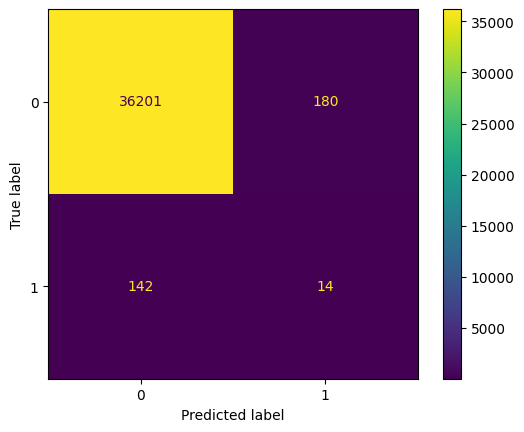

In [374]:
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred_binary)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1 Score:', f1)
print('AUC:', auc)


ConfusionMatrixDisplay(confusion).plot()

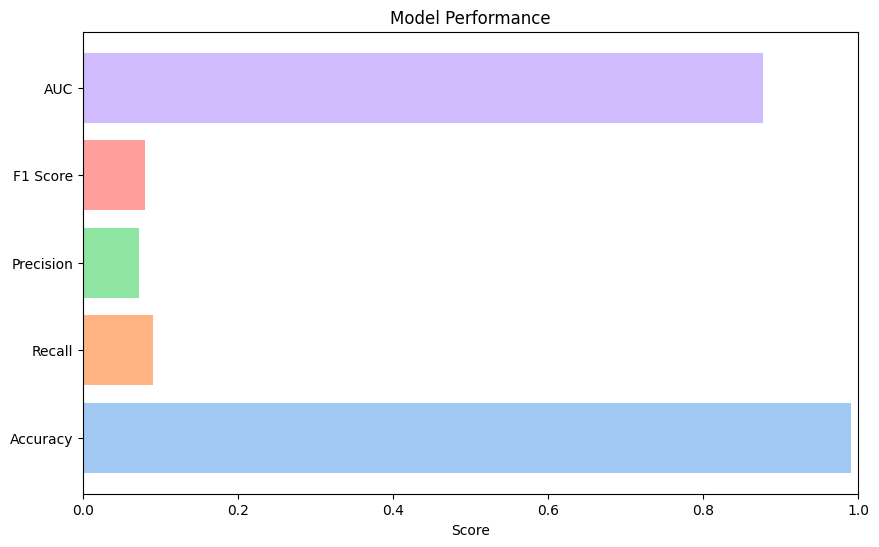

In [375]:
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC']
values = [accuracy, recall, precision, f1, auc]
colors = sns.color_palette('pastel', len(metrics))

plt.figure(figsize=(10, 6))
plt.barh(metrics, values, color=colors)
plt.xlabel('Score')
plt.title('Model Performance')
plt.xlim(0, 1)
plt.show()

In [376]:
from sklearn.metrics import average_precision_score, auc

precision2, recall2, threshold = precision_recall_curve(y_test, y_pred_binary)
prauc = auc(precision2, recall2)
print("PRAUC: ", prauc)


PRAUC:  0.07862786025277148


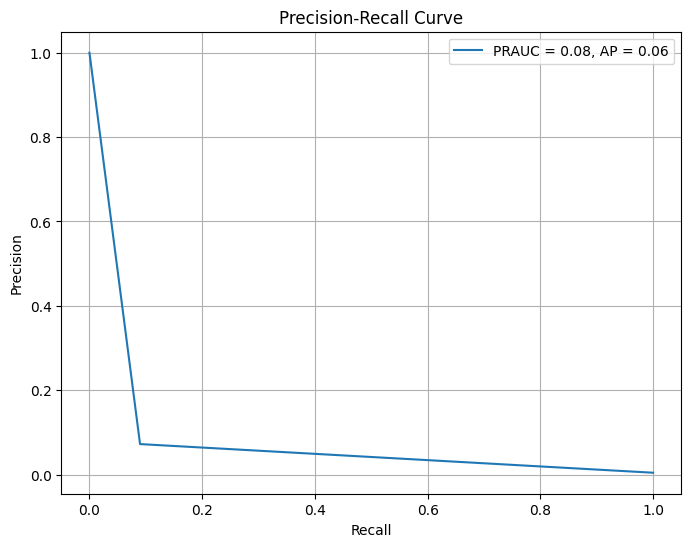

In [377]:
# Calculate the Average Precision (AP) to display in the plot
ap = average_precision_score(y_test, y_pred)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall2, precision2, label=f'PRAUC = {prauc:.2f}, AP = {ap:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

In [378]:
importance = pd.DataFrame({'feature': x_train.columns, 'importance': gbm.feature_importance()})
importance = importance.sort_values('importance', ascending=False)
print(importance)

                        feature  importance
32            price_to_earnings         194
24            net_profit_margin         174
25             return_on_assets         173
2                      dtdlevel         157
11                        sigma         128
22                 equity_ratio         124
3                      dtdtrend         103
20                   debt_ratio         100
9                     sizetrend          98
19          net_working_capital          93
21         debt_to_equity_ratio          91
10                          m2b          90
15              DTDmedianNonFin          87
35           gross_margin_ratio          86
23       cashflow_to_debt_ratio          85
39      interest_coverage_ratio          85
16                current_ratio          81
8                     sizelevel          79
37                ebitda_margin          79
26               asset_turnover          78
33        dividend_payout_ratio          76
29         receivables_turnover 

c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


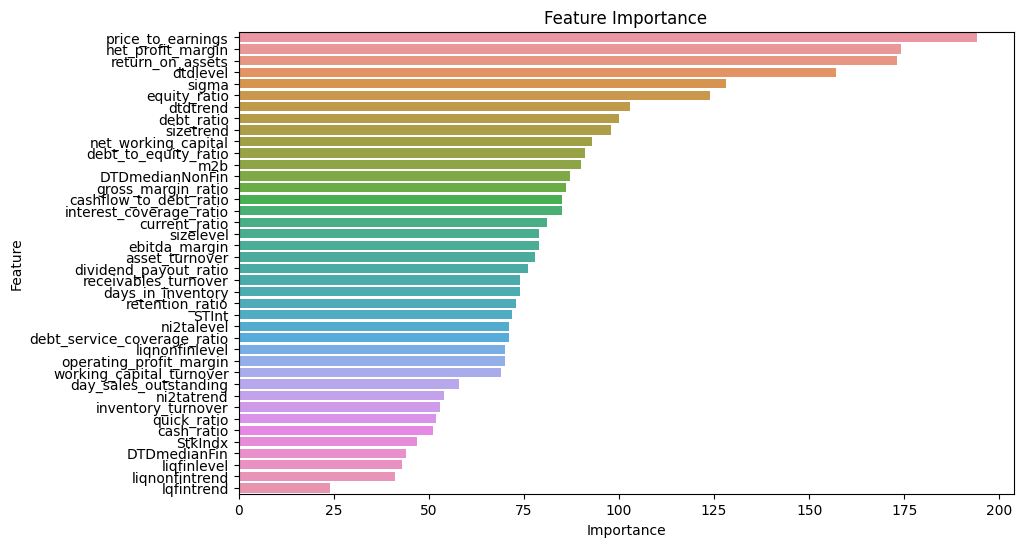

In [379]:
feature_importance = gbm.feature_importance()
features = x_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance')
plt.show()

c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

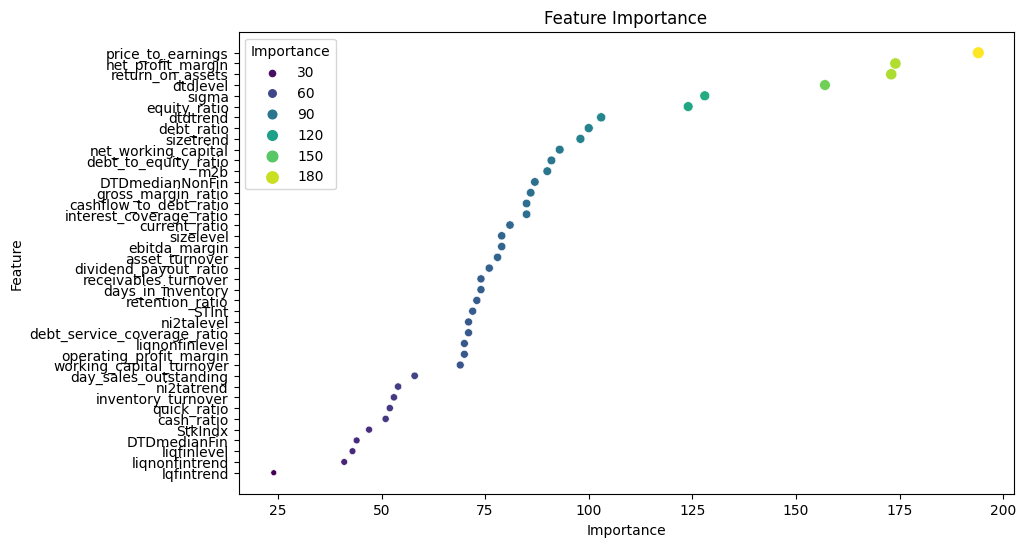

In [380]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False), size='Importance', hue='Importance', palette='viridis')
plt.title('Feature Importance')
plt.show()

In [381]:
#Precision OPTIMIZED
results = pd.DataFrame({'Recall': [recall], 'Precision': [precision], 'F1 Score': [f1], 'AUC': [auc]})
results.to_csv(path + 'LGB_all_factors_results_aucoptimized.csv', index=False)

best_params_df = pd.DataFrame(best_params, index=[0])
best_params_df.to_csv(path + 'best_params_lgb_allfactors_aucoptimized.csv', index=False)

gbm.save_model(path + 'model_lgb_allfactors_aucoptimized.txt')

Load one model and Plot performances

Accuracy: 0.9954019213400115
Recall: 0.19230769230769232
Precision: 0.4166666666666667
F1 Score: 0.2631578947368421
AUC: 0.9673462972712581


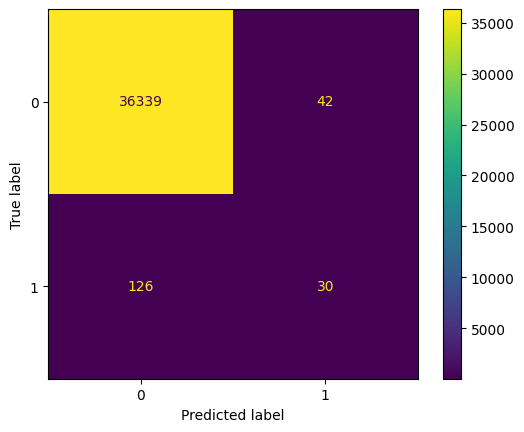

In [382]:
path_to_model = path + "model_lgb_allfactors_aucoptimized.txt"
gbm = lgb.Booster(model_file=path_to_model)

y_pred = gbm.predict(x_test)
y_pred_binary = np.round(y_pred)

accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred_binary)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1 Score:', f1)
print('AUC:', auc)

ConfusionMatrixDisplay(confusion).plot()

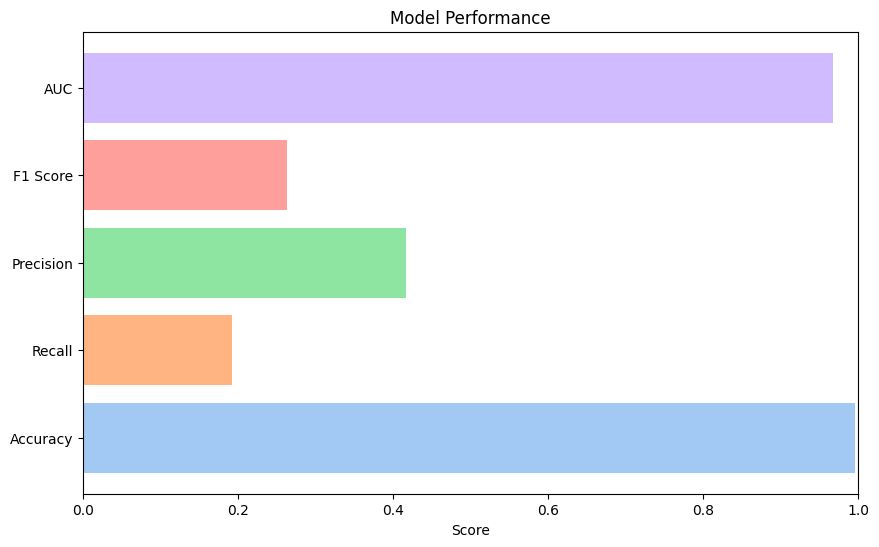

In [383]:
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC']
values = [accuracy, recall, precision, f1, auc]
colors = sns.color_palette('pastel', len(metrics))

plt.figure(figsize=(10, 6))
plt.barh(metrics, values, color=colors)
plt.xlabel('Score')
plt.title('Model Performance')
plt.xlim(0, 1)
plt.show()

In [384]:
importance = pd.DataFrame({'feature': x_train.columns, 'importance': gbm.feature_importance()})
importance = importance.sort_values('importance', ascending=False)
print(importance)

                        feature  importance
1                         STInt         756
19          net_working_capital         748
8                     sizelevel         728
22                 equity_ratio         724
29         receivables_turnover         700
20                   debt_ratio         685
4                liqnonfinlevel         656
26               asset_turnover         642
10                          m2b         631
17                  quick_ratio         611
35           gross_margin_ratio         608
30        day_sales_outstanding         592
2                      dtdlevel         584
27           inventory_turnover         577
16                current_ratio         568
6                    ni2talevel         561
15              DTDmedianNonFin         554
38  debt_service_coverage_ratio         539
23       cashflow_to_debt_ratio         536
39      interest_coverage_ratio         530
21         debt_to_equity_ratio         520
18                   cash_ratio 

c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


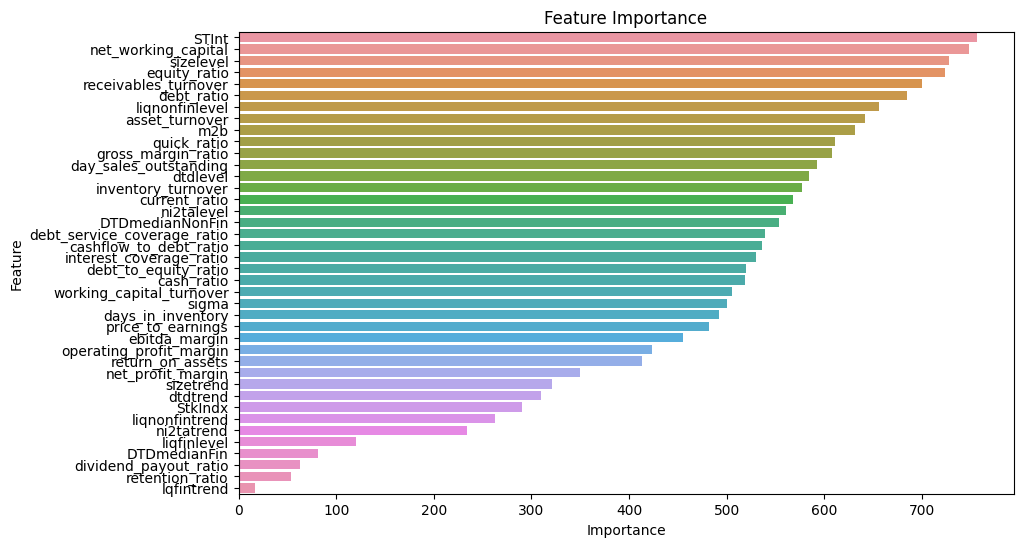

In [385]:
feature_importance = gbm.feature_importance()
features = x_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance')
plt.show()

c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

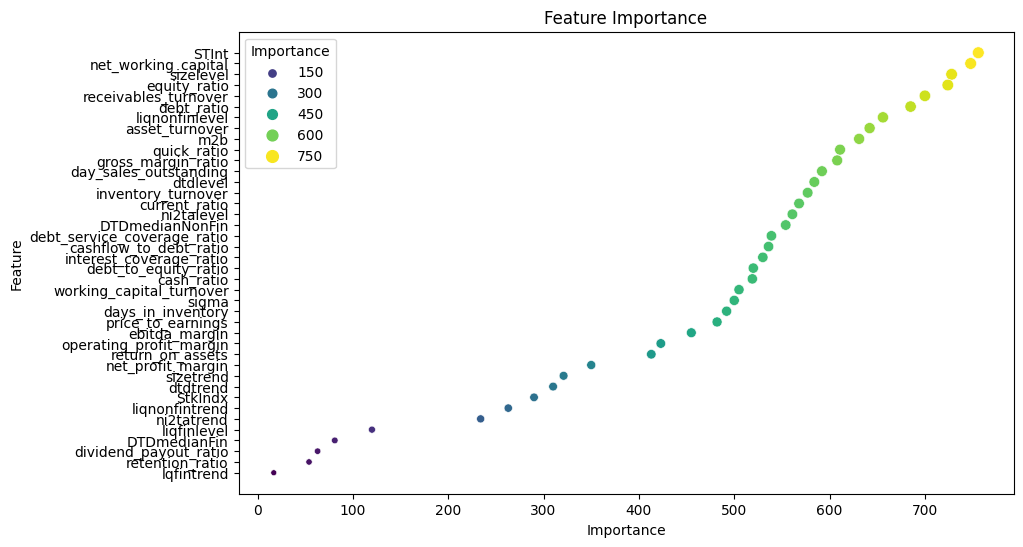

In [386]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False), size='Importance', hue='Importance', palette='viridis')
plt.title('Feature Importance')
plt.show()

Load 3 models and compare performances


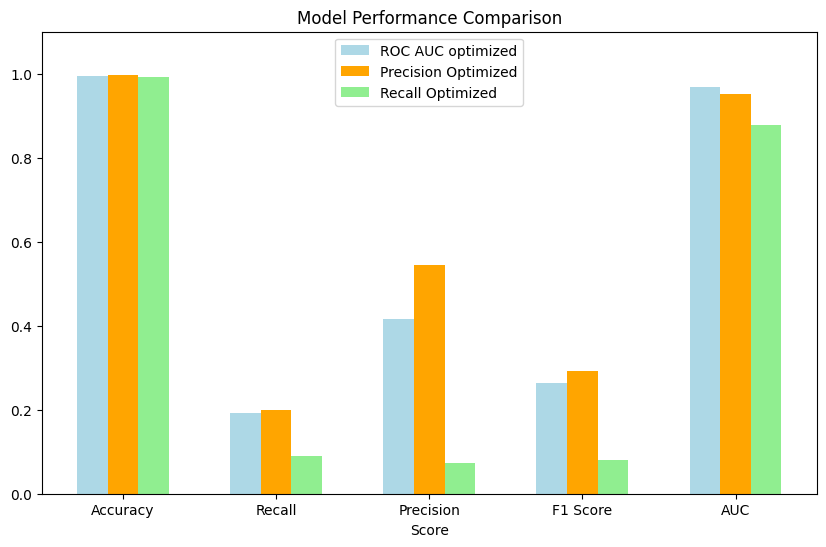

c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

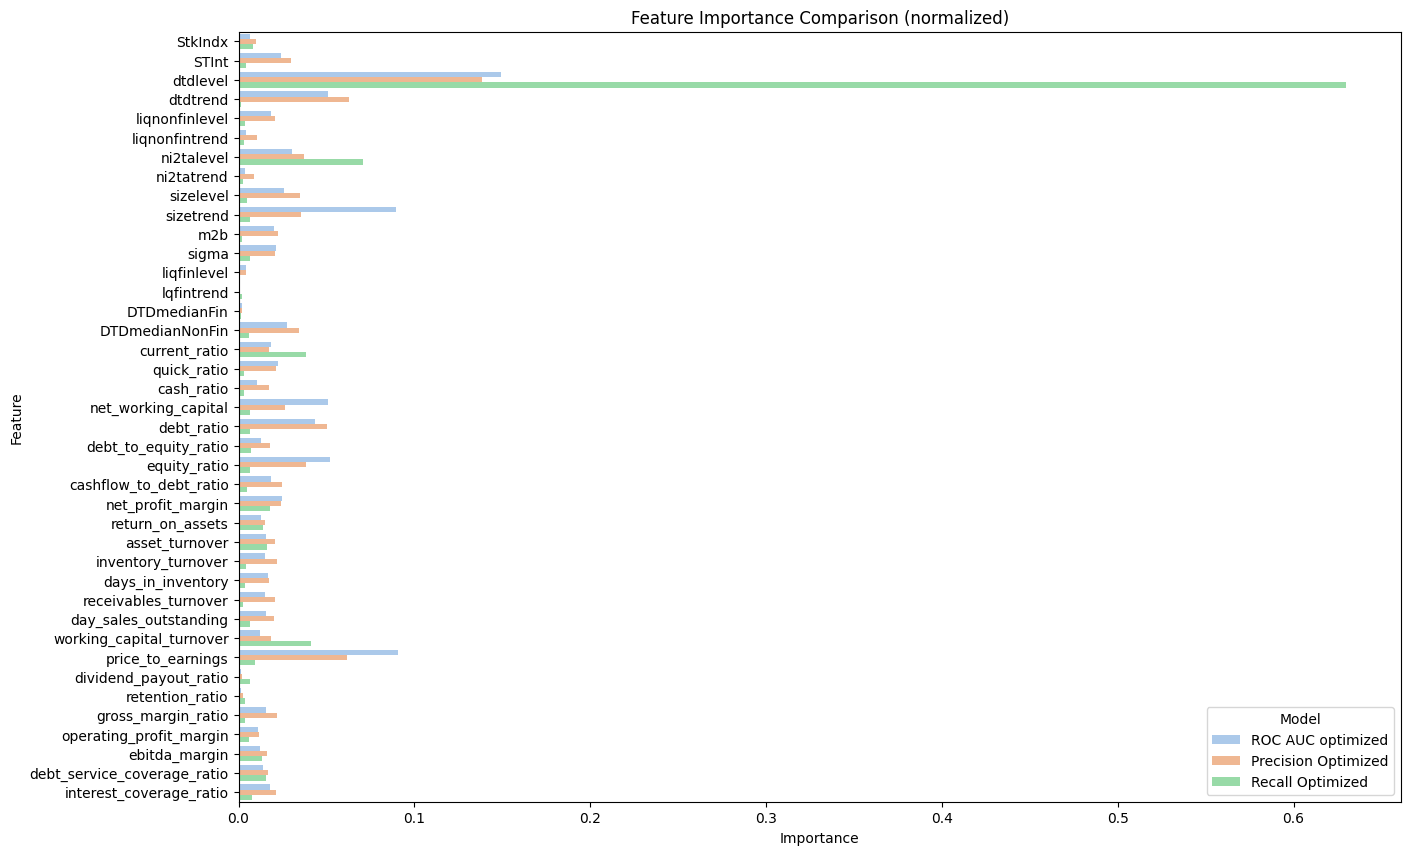

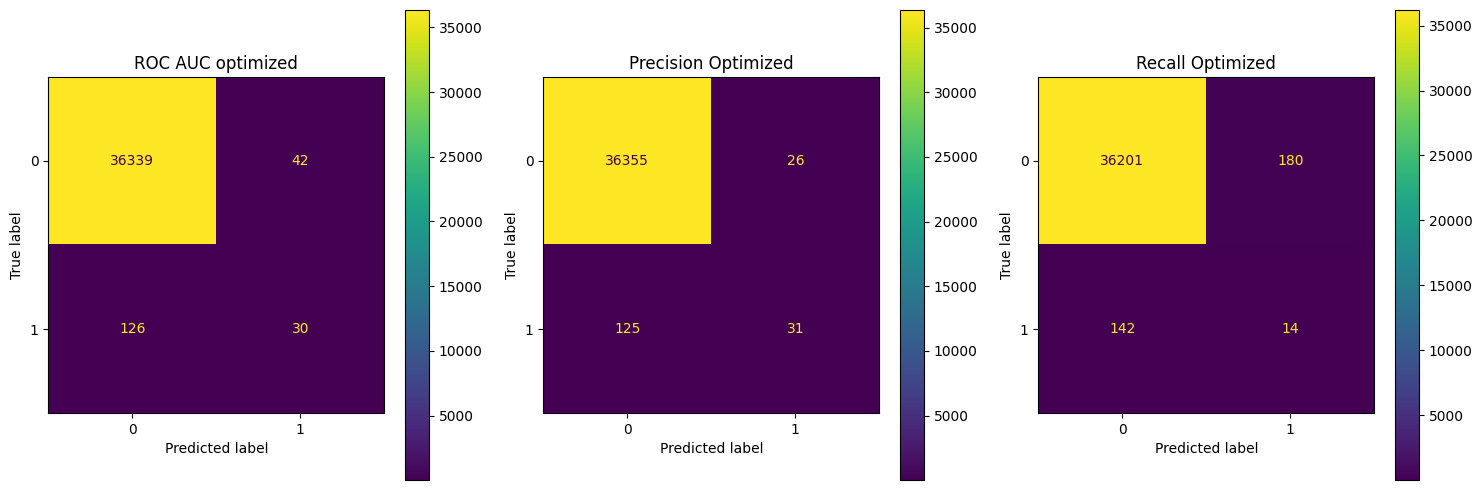

In [387]:
# Load the models
bst1 = lgb.Booster(model_file= path + 'model_lgb_allfactors_aucoptimized.txt')
bst2 = lgb.Booster(model_file= path + 'model_lgb_allfactors_precisionoptimized.txt')
bst3 = lgb.Booster(model_file= path + 'model_lgb_allfactors_recalloptimized.txt')

# Predict the test data
y_pred1 = bst1.predict(x_test)
y_pred2 = bst2.predict(x_test)
y_pred3 = bst3.predict(x_test)

# Calculate the metrics
accuracy1 = accuracy_score(y_test, np.round(y_pred1))
recall1 = recall_score(y_test, np.round(y_pred1))
precision1 = precision_score(y_test, np.round(y_pred1))
f1_1 = f1_score(y_test, np.round(y_pred1))
auc1 = roc_auc_score(y_test, y_pred1)

accuracy2 = accuracy_score(y_test, np.round(y_pred2))
recall2 = recall_score(y_test, np.round(y_pred2))
precision2 = precision_score(y_test, np.round(y_pred2))
f1_2 = f1_score(y_test, np.round(y_pred2))
auc2 = roc_auc_score(y_test, y_pred2)

accuracy3 = accuracy_score(y_test, np.round(y_pred3))
recall3 = recall_score(y_test, np.round(y_pred3))
precision3 = precision_score(y_test, np.round(y_pred3))
f1_3 = f1_score(y_test, np.round(y_pred3))
auc3 = roc_auc_score(y_test, y_pred3)

metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC']
values1 = [accuracy1, recall1, precision1, f1_1, auc1]
values2 = [accuracy2, recall2, precision2, f1_2, auc2]
values3 = [accuracy3, recall3, precision3, f1_3, auc3]

x = np.arange(len(metrics))

plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, values1, 0.2, color='lightblue', label='ROC AUC optimized')
plt.bar(x, values2, 0.2, color='orange', label='Precision Optimized')
plt.bar(x + 0.2, values3, 0.2, color='lightgreen', label='Recall Optimized')
plt.xticks(x, metrics)
plt.xlabel('Score')
plt.title('Model Performance Comparison')
plt.ylim(0, 1.1)
plt.legend()
plt.show()

importance1 = bst1.feature_importance(importance_type='gain')
importance2 = bst2.feature_importance(importance_type='gain')
importance3 = bst3.feature_importance(importance_type='gain')

# Normalize the feature importance
importance1 = importance1 / sum(importance1)
importance2 = importance2 / sum(importance2)
importance3 = importance3 / sum(importance3)

# # Plot the feature importance
importance_df = pd.DataFrame({'Feature': x_test.columns, 'ROC AUC optimized': importance1, 'Precision Optimized': importance2, 'Recall Optimized': importance3})

importance_df = importance_df.melt('Feature', var_name='Model', value_name='Importance')

plt.figure(figsize=(15, 10))
sns.barplot(x='Importance', y='Feature', hue='Model', data=importance_df, palette='pastel')
plt.title('Feature Importance Comparison (normalized)')
plt.show()

# Calculate the confusion matrices
confusion1 = confusion_matrix(y_test, np.round(y_pred1))
confusion2 = confusion_matrix(y_test, np.round(y_pred2))
confusion3 = confusion_matrix(y_test, np.round(y_pred3))

# Plot the confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ConfusionMatrixDisplay(confusion1).plot(ax=axes[0], cmap='viridis')
axes[0].set_title('ROC AUC optimized')

ConfusionMatrixDisplay(confusion2).plot(ax=axes[1], cmap='viridis')
axes[1].set_title('Precision Optimized')

ConfusionMatrixDisplay(confusion3).plot(ax=axes[2], cmap='viridis')
axes[2].set_title('Recall Optimized')

plt.tight_layout()
plt.show()

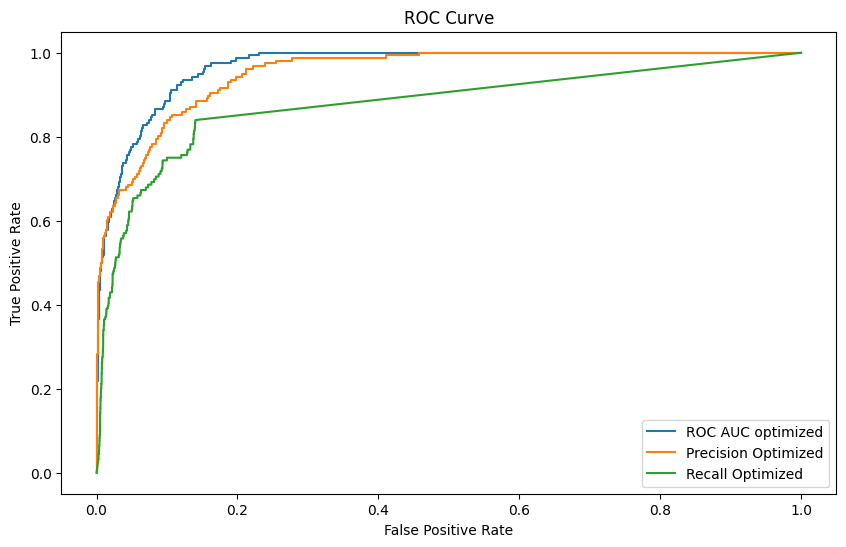

In [388]:
fpr1, tpr1, _ = roc_curve(y_test, y_pred1)
fpr2, tpr2, _ = roc_curve(y_test, y_pred2)
fpr3, tpr3, _ = roc_curve(y_test, y_pred3)

plt.figure(figsize=(10, 6))
plt.plot(fpr1, tpr1, label='ROC AUC optimized')
plt.plot(fpr2, tpr2, label='Precision Optimized')
plt.plot(fpr3, tpr3, label='Recall Optimized')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

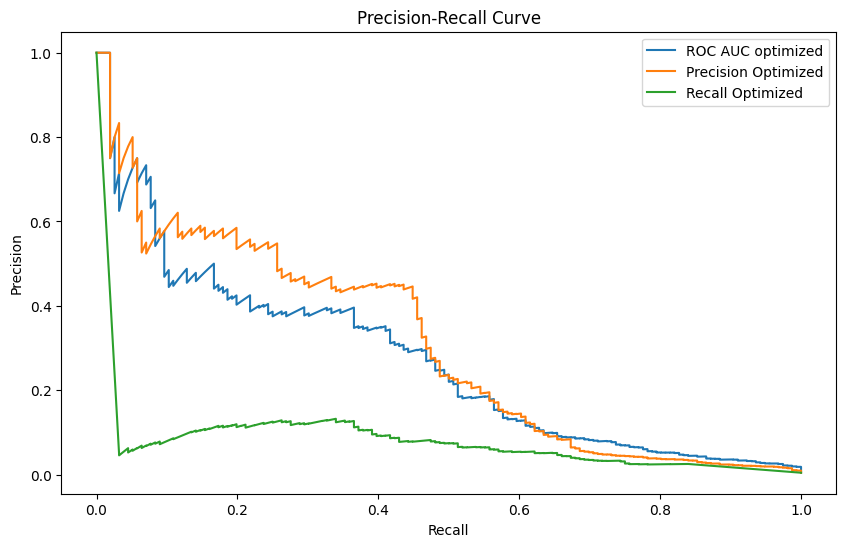

In [389]:
precision1, recall1, _ = precision_recall_curve(y_test, y_pred1)
precision2, recall2, _ = precision_recall_curve(y_test, y_pred2)
precision3, recall3, _ = precision_recall_curve(y_test, y_pred3)

plt.figure(figsize=(10, 6))
plt.plot(recall1, precision1, label='ROC AUC optimized')
plt.plot(recall2, precision2, label='Precision Optimized')
plt.plot(recall3, precision3, label='Recall Optimized')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

Model l
Feature: 0
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 1
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 2
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 3
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 4
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 5
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 6
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 7
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 8
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7
Repeat:8
Repeat:9
Feature: 9
Repeat:0
Repeat:1
Repeat:2
Repeat:3
Repeat:4
Repeat:5
Repeat:6
Repeat:7


c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

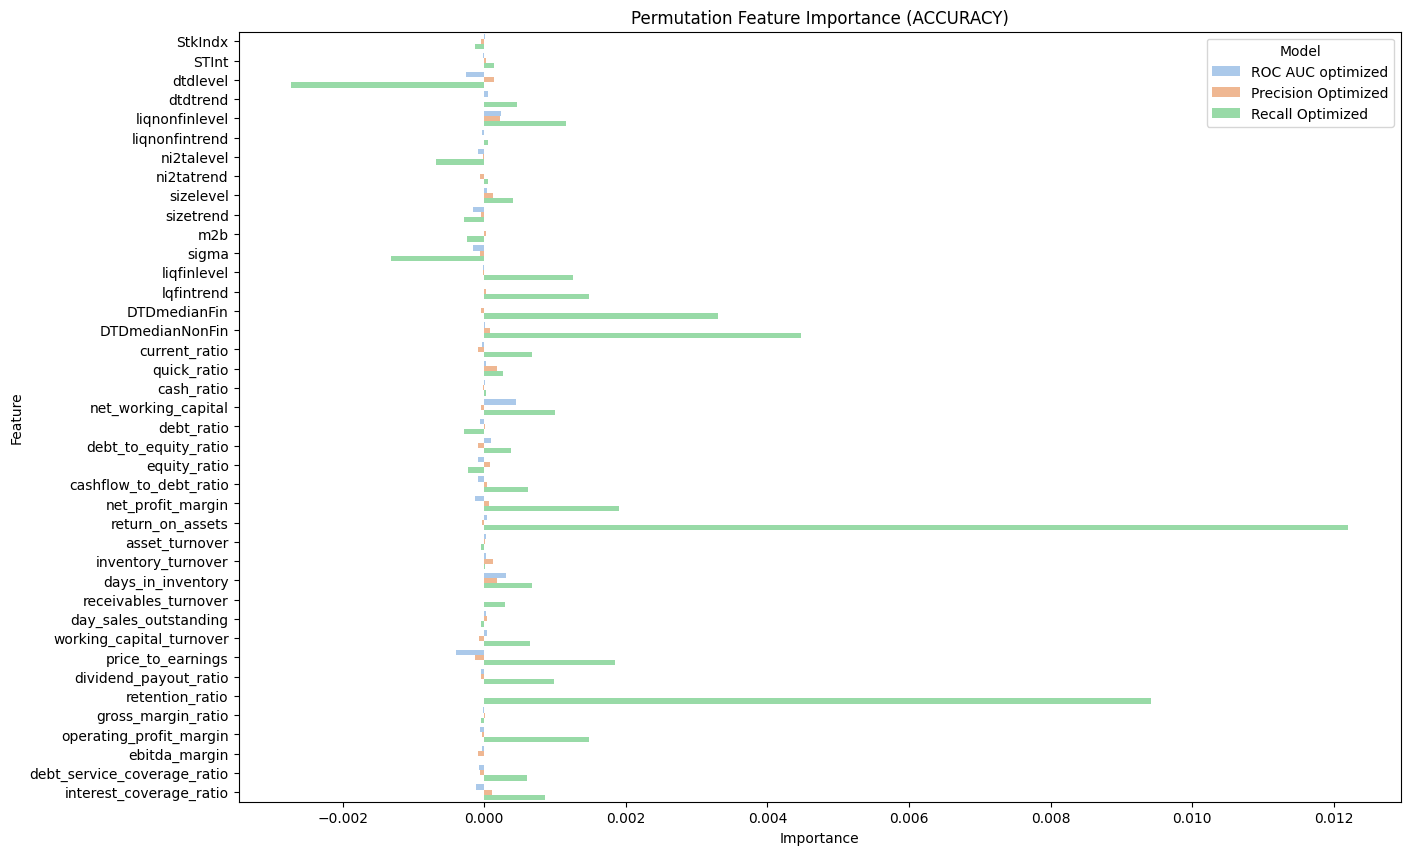

In [390]:
# BASED ON ACCURACY
def permutation_importance(model, X, y, scoring, n_repeats, random_state):
    baseline_score = scoring(y, np.round(model.predict(X)))
    scores = np.zeros((X.shape[1], n_repeats))
    rng = np.random.RandomState(random_state)
    
    for feature in range(X.shape[1]):
        print("Feature: " + str(feature))
        X_permuted = X.copy()
        for repeat in range(n_repeats):
            print("Repeat:" + str(repeat))
            X_permuted.iloc[:, feature] = rng.permutation(X_permuted.iloc[:, feature])
            score = scoring(y, np.round(model.predict(X_permuted)))
            scores[feature, repeat] = baseline_score - score
    
    return scores

print("Model l")
perm_importance1 = permutation_importance(bst1, x_test, y_test, accuracy_score, n_repeats=10, random_state=42)
print("Model 3")
perm_importance2 = permutation_importance(bst2, x_test, y_test, accuracy_score, n_repeats=10, random_state=42)
print("Model 3")
perm_importance3 = permutation_importance(bst3, x_test, y_test, accuracy_score, n_repeats=10, random_state=42)

perm_importance_df = pd.DataFrame({'Feature': x_test.columns, 'ROC AUC optimized': np.mean(perm_importance1, axis=1), 'Precision Optimized': np.mean(perm_importance2, axis=1), 'Recall Optimized': np.mean(perm_importance3, axis=1)})

perm_importance_df = perm_importance_df.melt('Feature', var_name='Model', value_name='Importance')

plt.figure(figsize=(15, 10))
sns.barplot(x='Importance', y='Feature', hue='Model', data=perm_importance_df, palette='pastel')
plt.title('Permutation Feature Importance (ACCURACY)')
plt.show()

Model l
Model 3
Model 3


c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Documents\Capstone\.venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.

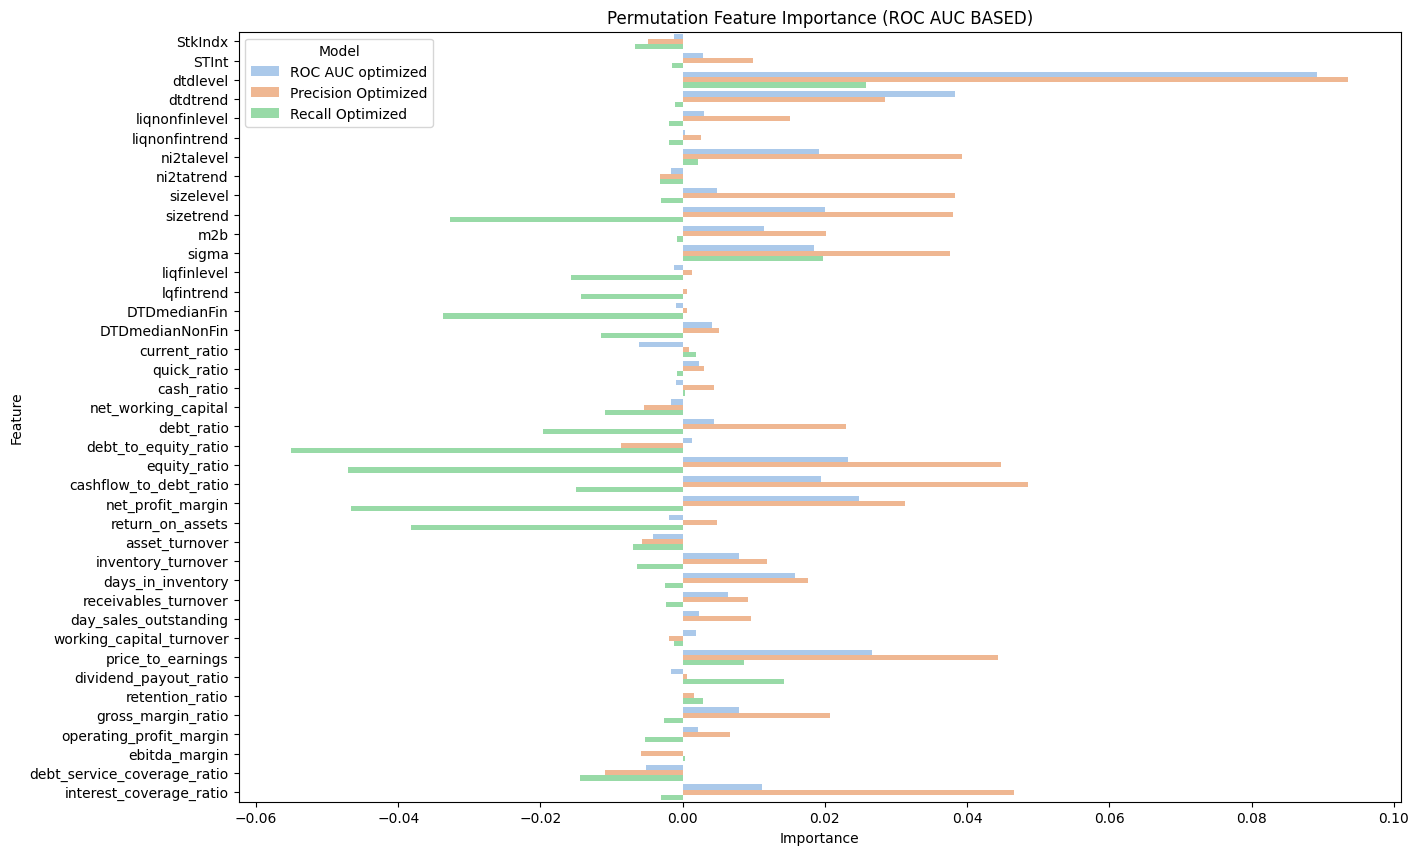

In [391]:
# BASED ON ROC AUC
def permutation_importance(model, X, y, scoring, n_repeats, random_state):
    baseline_score = scoring(y, np.round(model.predict(X)))
    scores = np.zeros((X.shape[1], n_repeats))
    rng = np.random.RandomState(random_state)
    
    for feature in range(X.shape[1]):
        X_permuted = X.copy()
        for repeat in range(n_repeats):
            X_permuted.iloc[:, feature] = rng.permutation(X_permuted.iloc[:, feature])
            score = scoring(y, np.round(model.predict(X_permuted)))
            scores[feature, repeat] = baseline_score - score
    
    return scores

print("Model l")
perm_importance1 = permutation_importance(bst1, x_test, y_test, roc_auc_score, n_repeats=10, random_state=42)
print("Model 3")
perm_importance2 = permutation_importance(bst2, x_test, y_test, roc_auc_score, n_repeats=10, random_state=42)
print("Model 3")
perm_importance3 = permutation_importance(bst3, x_test, y_test, roc_auc_score, n_repeats=10, random_state=42)

perm_importance_df = pd.DataFrame({'Feature': x_test.columns, 'ROC AUC optimized': np.mean(perm_importance1, axis=1), 'Precision Optimized': np.mean(perm_importance2, axis=1), 'Recall Optimized': np.mean(perm_importance3, axis=1)})

perm_importance_df = perm_importance_df.melt('Feature', var_name='Model', value_name='Importance')

plt.figure(figsize=(15, 10))
sns.barplot(x='Importance', y='Feature', hue='Model', data=perm_importance_df, palette='pastel')
plt.title('Permutation Feature Importance (ROC AUC BASED)')
plt.show()